# **5. Training**

This section covers the training of models for linguistic acceptability in Dutch. It compares different models, including multilingual BERT, BERTje, RobBERT, and XLM-RoBERTa, using a dataset of Dutch sentences labeled as acceptable or unacceptable. The models are evaluated based on their predictions and confusion matrices. The dataset is also compared to the CoLA dataset, which is used for English acceptability judgments.

In [6]:
import yaml

# Load configuration from YAML file
with open('config.yaml', 'r') as file:
    config = yaml.safe_load(file)

## **Labeling**
| from_version → to_version | keep which sentence? | assign label      |
|--------------------------|----------------------|-------------------|
| 1 → 2                    | old_sentence         | 0 (unacceptable)  |
| 2 → 3                    | new_sentence         | 1 (acceptable)    |
| 1 → 3 (v2 gap)           | old_sentence 0 and new_sentence 1 |         |

## **Turn pairs into “sentence, label” rows**

In [7]:
import pandas as pd

df = pd.read_parquet(config['gpt_filtered_file'])

# Define linguistic categories
linguistic_categories = [
    'Grammar',
    'Spelling / Typos', 
    'Article Change',
    'Preposition Change',
    'Punctuation',
    'Capitalization',
    'Sentence Structure'
]

print("=== DATASET CREATION FOR BINARY CLASSIFICATION ===")
print(f"Original dataset size: {len(df):,} rows")

# Filter to only linguistic edits
df = df[df['category'].isin(linguistic_categories)].copy()
print(f"After filtering to linguistic categories: {len(df):,} rows")


records = []
for _, row in df.iterrows():
    fv, tv = row['from_version'], row['to_version']

    if fv == 1 and tv == 2:              # rough → better
        records.append({"sentence": row['old_sentence'],
                        "label": 0,
                        "isbn":  row['isbn']})

    elif fv == 2 and tv == 3:            # better → polished
        records.append({"sentence": row['new_sentence'],
                        "label": 1,
                        "isbn":  row['isbn']})

    elif fv == 1 and tv == 3:            # gap case: keep both
        records.append({"sentence": row['old_sentence'],
                        "label": 0,
                        "isbn":  row['isbn']})
        records.append({"sentence": row['new_sentence'],
                        "label": 1,
                        "isbn":  row['isbn']})

dataset = pd.DataFrame(records)

# deduplicate identical surface strings
print(f"Initial dataset size: {len(dataset):,} records")
dataset = dataset.drop_duplicates(subset=["sentence"])
print(f"After deduplication: {len(dataset):,} records")

=== DATASET CREATION FOR BINARY CLASSIFICATION ===
Original dataset size: 23,623 rows
After filtering to linguistic categories: 13,140 rows
Initial dataset size: 13,686 records
After deduplication: 12,894 records


In [8]:
# print distribution of labels
print("\nLabel distribution:")
label_counts = dataset['label'].value_counts()
for label, count in label_counts.items():
    pct = (count / len(dataset)) * 100
    print(f"   {label}: {count:,} records ({pct:.1f}%)")


Label distribution:
   1: 10,153 records (78.7%)
   0: 2,741 records (21.3%)


## **Group-wise train / validation / test split**

In [9]:
from sklearn.model_selection import GroupShuffleSplit
import pandas as pd

# first: TRAIN+VAL vs TEST (10 % test) 
gss = GroupShuffleSplit(n_splits=1, test_size=0.10, random_state=42)

train_val_idx, test_idx = next(gss.split(dataset,
                                         groups=dataset['isbn']))

train_val_df = dataset.iloc[train_val_idx].reset_index(drop=True)   # 90 %
test_df      = dataset.iloc[test_idx].reset_index(drop=True)        # 10 %

# second: TRAIN vs VAL (10 % of the 90 % → 9 % absolute)
gss_val = GroupShuffleSplit(n_splits=1, test_size=0.10, random_state=42)

train_idx, val_idx = next(gss_val.split(train_val_df,
                                        groups=train_val_df['isbn']))

train_df = train_val_df.iloc[train_idx].reset_index(drop=True)      # 81 %
val_df   = train_val_df.iloc[val_idx  ].reset_index(drop=True)      #  9 %

for name, df_ in [("train", train_df), ("val", val_df), ("test", test_df)]:
    print(f"{name:<5}  rows = {len(df_):>6}   label counts:\n{df_['label'].value_counts()}\n")


train  rows =  10455   label counts:
label
1    8215
0    2240
Name: count, dtype: int64

val    rows =   1163   label counts:
label
1    930
0    233
Name: count, dtype: int64

test   rows =   1276   label counts:
label
1    1008
0     268
Name: count, dtype: int64



## **Create Dataset objects and Fine-tune**

In [10]:
print("Label counts BEFORE balancing:")
print(train_df["label"].value_counts(dropna=False))

Label counts BEFORE balancing:
label
1    8215
0    2240
Name: count, dtype: int64


In [11]:
import numpy as np
import pandas as pd
from datasets import Dataset
from transformers import AutoTokenizer

model_name = "google-bert/bert-base-multilingual-cased"
tok = AutoTokenizer.from_pretrained(model_name)

# Undersampling the majority class in the training set
rng = 42  # for reproducibility

# Count how many examples we have per class in train split
counts = train_df["label"].value_counts()        
minority_class = counts.idxmin()               
minority_n     = counts.min()                 

# Separate the two label groups
df_min = train_df[train_df.label == minority_class]               # keep all
df_maj = train_df[train_df.label != minority_class]               # will sample

# Undersample the majority class to the same size as minority
df_maj_sample = df_maj.sample(n=minority_n, random_state=rng, replace=False)

# Recombine and shuffle
train_df_bal = (pd.concat([df_min, df_maj_sample])
                  .sample(frac=1, random_state=rng)
                  .reset_index(drop=True))

print("After balancing:")
print(train_df_bal["label"].value_counts())      
# ─────────────────────────────────────────────────────────────────────────

# Turn the DataFrames into dataset wrappers
train_ds = Dataset.from_pandas(train_df_bal)   
val_ds   = Dataset.from_pandas(val_df)         
test_ds  = Dataset.from_pandas(test_df)

# Tokenize the datasets
def tok_func(batch):
    return tok(batch["sentence"],
               padding="max_length",
               truncation=True,
               max_length=128)

train_ds = train_ds.map(tok_func, batched=True)
val_ds   = val_ds.map(tok_func, batched=True)
test_ds  = test_ds.map(tok_func, batched=True)

# keep only the columns PyTorch needs
cols = ["input_ids", "attention_mask", "label"]
for d in (train_ds, val_ds, test_ds):
    d.set_format(type="torch", columns=cols)


After balancing:
label
0    2240
1    2240
Name: count, dtype: int64


Map: 100%|██████████| 1276/1276 [00:00<00:00, 16997.87 examples/s]


In [12]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, f1_score

model = AutoModelForSequenceClassification.from_pretrained(
            model_name,
            num_labels=2)

def compute_metrics(pred):
    logits, labels = pred
    preds = logits.argmax(axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1":       f1_score(labels, preds)
    }

args = TrainingArguments(
    eval_strategy="epoch",
    num_train_epochs=3,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_steps=100,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,  
    eval_dataset=val_ds,
    tokenizer=tok,
    compute_metrics=compute_metrics,
)

trainer.train()
eval_results = trainer.evaluate(test_ds)
print(eval_results)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\kevin\AppData\Local\Temp\ipykernel_14856\2539963338.py:26: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.638000,0.786537,0.528805,0.598240
2,0.559100,0.701416,0.656922,0.742747
3,0.442400,0.736274,0.681857,0.767296


{'eval_loss': 0.6848504543304443, 'eval_accuracy': 0.6990595611285266, 'eval_f1': 0.7810718358038768, 'eval_runtime': 2.2744, 'eval_samples_per_second': 561.017, 'eval_steps_per_second': 17.587, 'epoch': 3.0}


# **Evaluate model performance**


Classification Report for model google-bert/bert-base-multilingual-cased:
              precision    recall  f1-score   support

           0      0.391     0.772     0.519       268
           1      0.918     0.680     0.781      1008

    accuracy                          0.699      1276
   macro avg      0.654     0.726     0.650      1276
weighted avg      0.807     0.699     0.726      1276

Confusion matrix (rows = true, cols = pred):
 [[207  61]
 [323 685]]


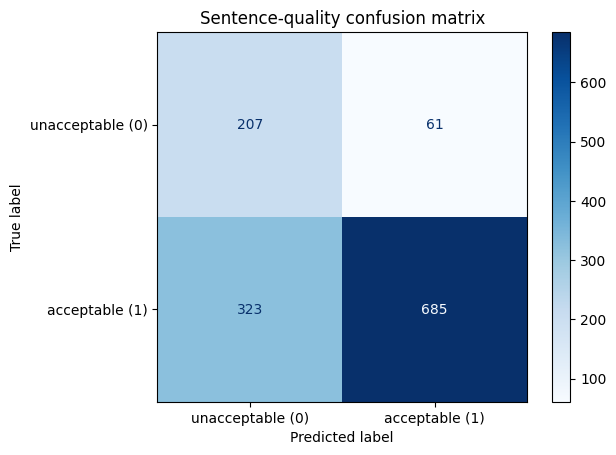

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Get predictions
pred_out  = trainer.predict(test_ds)
y_true    = pred_out.label_ids
y_pred    = np.argmax(pred_out.predictions, axis=-1)

# Save predictions to a CSV file
pred_df = pd.DataFrame({    
    "true_label": y_true,
    "predicted_label": y_pred,
    "sentence": test_ds["sentence"]
})

pred_df.to_csv("model_predictions/" + model_name.replace("/", "_") + "_predictions.csv", index=False)

# Print classification report
from sklearn.metrics import classification_report
print("\nClassification Report for model " + model_name + ":")
print("="*50)
print(classification_report(y_true, y_pred, digits=3))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix (rows = true, cols = pred):\n", cm)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(cm, display_labels=["unacceptable (0)", "acceptable (1)"])
disp.plot(values_format='d', cmap='Blues')
plt.title("Sentence-quality confusion matrix")
plt.show()


## **Threshold Analysis**


Threshold: 0.2
Confusion matrix:
[[162 106]
 [191 817]]
Recall (unacceptable): 0.604
Precision (unacceptable): 0.459
F1 Score (unacceptable): 0.522
Recall (acceptable): 0.811
Precision (acceptable): 0.885
F1 Score (acceptable): 0.846
Accuracy: 0.767
False Positives (missed errors): 106
Total reviews needed (TN + FN): 353

Threshold: 0.3
Confusion matrix:
[[181  87]
 [246 762]]
Recall (unacceptable): 0.675
Precision (unacceptable): 0.424
F1 Score (unacceptable): 0.521
Recall (acceptable): 0.756
Precision (acceptable): 0.898
F1 Score (acceptable): 0.821
Accuracy: 0.739
False Positives (missed errors): 87
Total reviews needed (TN + FN): 427

Threshold: 0.4
Confusion matrix:
[[194  74]
 [286 722]]
Recall (unacceptable): 0.724
Precision (unacceptable): 0.404
F1 Score (unacceptable): 0.519
Recall (acceptable): 0.716
Precision (acceptable): 0.907
F1 Score (acceptable): 0.800
Accuracy: 0.718
False Positives (missed errors): 74
Total reviews needed (TN + FN): 480

Threshold: 0.5
Confusion matr

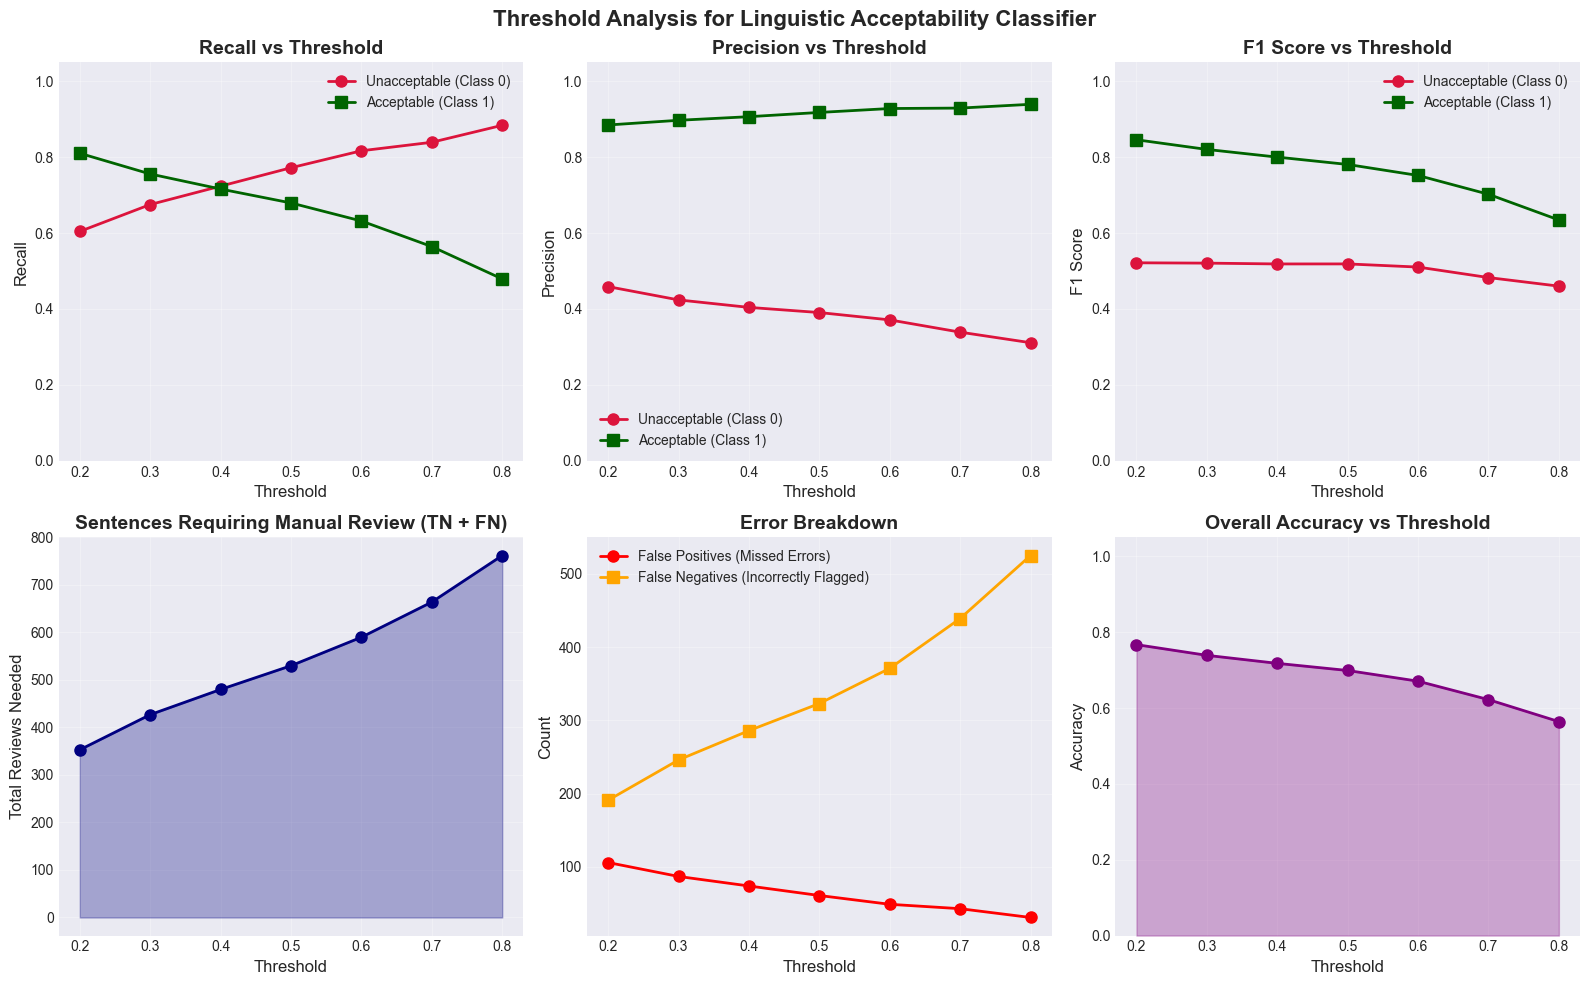

In [ ]:
from sklearn.metrics import confusion_matrix, precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np
import torch

# Get probabilities
test_probs = trainer.predict(test_ds).predictions
test_probs = torch.nn.functional.softmax(torch.from_numpy(test_probs), dim=-1).numpy()
test_labels = test_ds['label']

# Test different thresholds
thresholds = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
metrics = {
    'threshold': [],
    'recall_0': [],      # Recall for unacceptable (class 0)
    'precision_0': [],   # Precision for unacceptable
    'recall_1': [],      # Recall for acceptable (class 1)
    'precision_1': [],   # Precision for acceptable
    'f1_0': [],         # F1 for unacceptable
    'f1_1': [],         # F1 for acceptable
    'accuracy': [],
    'fp': [],          # False positives
    'tn': [],           # True negatives
    'fn': [],           # False negatives
    'total_reviews': [] # FP + FN (sentences needing review)
}

# Calculate metrics for each threshold
for threshold in thresholds:
    # If prob of class 1 (acceptable) > threshold, predict 1
    preds = (test_probs[:, 1] > threshold).astype(int)
    cm = confusion_matrix(test_labels, preds)
    
    # Extract values from confusion matrix
    tn = cm[0, 0]  
    fp = cm[0, 1]  
    fn = cm[1, 0]  
    tp = cm[1, 1]  
    
    # Calculate metrics
    recall_0 = tn / (tn + fp) if (tn + fp) > 0 else 0
    precision_0 = tn / (tn + fn) if (tn + fn) > 0 else 0
    recall_1 = tp / (tp + fn) if (tp + fn) > 0 else 0
    precision_1 = tp / (tp + fp) if (tp + fp) > 0 else 0
    
    f1_0 = 2 * (precision_0 * recall_0) / (precision_0 + recall_0) if (precision_0 + recall_0) > 0 else 0
    f1_1 = 2 * (precision_1 * recall_1) / (precision_1 + recall_1) if (precision_1 + recall_1) > 0 else 0
    
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    
    # Store metrics
    metrics['threshold'].append(threshold)
    metrics['recall_0'].append(recall_0)
    metrics['precision_0'].append(precision_0)
    metrics['recall_1'].append(recall_1)
    metrics['precision_1'].append(precision_1)
    metrics['f1_0'].append(f1_0)
    metrics['f1_1'].append(f1_1)
    metrics['accuracy'].append(accuracy)
    metrics['fp'].append(fp)
    metrics['tn'].append(tn)
    metrics['fn'].append(fn)
    metrics['total_reviews'].append(tn + fn)
    
    print(f"\nThreshold: {threshold}")
    print(f"Confusion matrix:\n{cm}")
    print(f"Recall (unacceptable): {recall_0:.3f}")
    print(f"Precision (unacceptable): {precision_0:.3f}")
    print(f"F1 Score (unacceptable): {f1_0:.3f}")
    print(f"Recall (acceptable): {recall_1:.3f}")
    print(f"Precision (acceptable): {precision_1:.3f}")
    print(f"F1 Score (acceptable): {f1_1:.3f}")
    print(f"Accuracy: {accuracy:.3f}")
    print(f"False Positives (missed errors): {fp}")
    print(f"Total reviews needed (TN + FN): {tn + fn}")

# Create visualizations
plt.style.use('seaborn-v0_8-darkgrid')
fig = plt.figure(figsize=(16, 10))

# Plot 1: Recall for both classes
ax1 = plt.subplot(2, 3, 1)
plt.plot(metrics['threshold'], metrics['recall_0'], 'o-', label='Unacceptable (Class 0)', 
         linewidth=2, markersize=8, color='crimson')
plt.plot(metrics['threshold'], metrics['recall_1'], 's-', label='Acceptable (Class 1)', 
         linewidth=2, markersize=8, color='darkgreen')
plt.xlabel('Threshold', fontsize=12)
plt.ylabel('Recall', fontsize=12)
plt.title('Recall vs Threshold', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 1.05)

# Plot 2: Precision for both classes
ax2 = plt.subplot(2, 3, 2)
plt.plot(metrics['threshold'], metrics['precision_0'], 'o-', label='Unacceptable (Class 0)', 
         linewidth=2, markersize=8, color='crimson')
plt.plot(metrics['threshold'], metrics['precision_1'], 's-', label='Acceptable (Class 1)', 
         linewidth=2, markersize=8, color='darkgreen')
plt.xlabel('Threshold', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision vs Threshold', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 1.05)

# Plot 3: F1 scores
ax3 = plt.subplot(2, 3, 3)
plt.plot(metrics['threshold'], metrics['f1_0'], 'o-', label='Unacceptable (Class 0)', 
         linewidth=2, markersize=8, color='crimson')
plt.plot(metrics['threshold'], metrics['f1_1'], 's-', label='Acceptable (Class 1)', 
         linewidth=2, markersize=8, color='darkgreen')
plt.xlabel('Threshold', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.title('F1 Score vs Threshold', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 1.05)

# Plot 4: Total reviews needed (TN + FN)
ax4 = plt.subplot(2, 3, 4)
plt.plot(metrics['threshold'], metrics['total_reviews'], 'o-', 
         linewidth=2, markersize=8, color='navy')
plt.fill_between(metrics['threshold'], metrics['total_reviews'], alpha=0.3, color='navy')
plt.xlabel('Threshold', fontsize=12)
plt.ylabel('Total Reviews Needed', fontsize=12)
plt.title('Sentences Requiring Manual Review (TN + FN)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# Plot 5: Breakdown of errors
ax5 = plt.subplot(2, 3, 5)
plt.plot(metrics['threshold'], metrics['fp'], 'o-', label='False Positives (Missed Errors)', 
         linewidth=2, markersize=8, color='red')
plt.plot(metrics['threshold'], metrics['fn'], 's-', label='False Negatives (Incorrectly Flagged)', 
         linewidth=2, markersize=8, color='orange')
plt.xlabel('Threshold', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Error Breakdown', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 6: Accuracy
ax6 = plt.subplot(2, 3, 6)
plt.plot(metrics['threshold'], metrics['accuracy'], 'o-', 
         linewidth=2, markersize=8, color='purple')
plt.fill_between(metrics['threshold'], metrics['accuracy'], alpha=0.3, color='purple')
plt.xlabel('Threshold', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Overall Accuracy vs Threshold', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.ylim(0, 1.05)

plt.suptitle('Threshold Analysis for Linguistic Acceptability Classifier', 
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

print("="*50)

## **CoLA Model Predidctions**

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer

model_name = "HylkeBr/robbert_dutch-cola"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

def tokenize_function(example):
    return tokenizer(example['sentence'], padding='max_length', truncation=True)

test_ds_tokenized = test_ds.map(tokenize_function, batched=True)

test_ds_tokenized.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

trainer = Trainer(model=model) 
pred_out = trainer.predict(test_ds_tokenized)
y_true = pred_out.label_ids
y_pred = np.argmax(pred_out.predictions, axis=-1)

# Save predictions to a CSV file
pred_df = pd.DataFrame({    
    "true_label": y_true,
    "predicted_label": y_pred,
    "sentence": test_ds["sentence"]
})

pred_df.to_csv("model_predictions/" + model_name.replace("/", "_") + "_predictions.csv", index=False)

## **Models Comparison**


Multilingual BERT:
  Unacceptable Precision: 0.391
  Unacceptable Recall: 0.772
  Overall Accuracy: 0.699

CoLA-NL:
  Unacceptable Precision: 0.224
  Unacceptable Recall: 0.041
  Overall Accuracy: 0.769



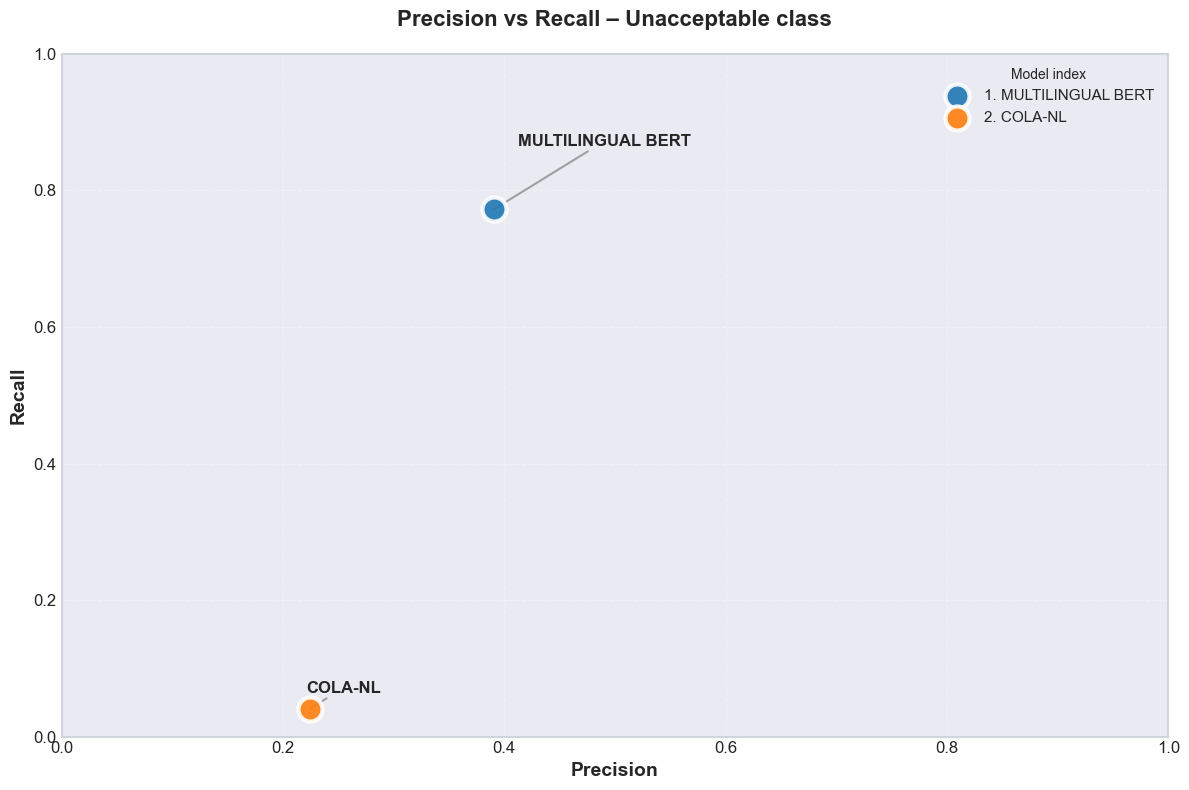

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import seaborn as sns
from pathlib import Path

# Define model names and colors
model_files = {
    'google-bert_bert-base-multilingual-cased_predictions.csv': 'Multilingual BERT',
    'GroNLP_bert-base-dutch-cased_predictions.csv': 'BERTje',
    'pdelobelle_robbert-v2-dutch-base_predictions.csv': 'RobBERT',
    'xlm-roberta-base_predictions.csv': 'XLM-RoBERTa',
    'HylkeBr_robbert_dutch-cola_predictions.csv': 'CoLA-NL'
}

# Standard colors
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
model_colors = {model: colors[i] for i, model in enumerate(model_files.values())}

# Calculate metrics for each model
model_metrics = {}
folder_path = Path('model_predictions')

for filename, model_name in model_files.items():
    file_path = folder_path / filename
    
    if file_path.exists():
        df = pd.read_csv(file_path)
        
        # Calculate precision, recall, f1 for each class
        precision, recall, f1, support = precision_recall_fscore_support(
            df['true_label'], df['predicted_label'], average=None
        )
        
        # Get metrics for unacceptable class (label 0)
        unacceptable_precision = precision[0]
        unacceptable_recall = recall[0]
        unacceptable_f1 = f1[0]
        
        # Overall accuracy
        accuracy = accuracy_score(df['true_label'], df['predicted_label'])
        
        model_metrics[model_name] = {
            'unacceptable_precision': unacceptable_precision,
            'unacceptable_recall': unacceptable_recall,
            'unacceptable_f1': unacceptable_f1,
            'accuracy': accuracy
        }
        
        print(f"{model_name}:")
        print(f"  Unacceptable Precision: {unacceptable_precision:.3f}")
        print(f"  Unacceptable Recall: {unacceptable_recall:.3f}")
        print(f"  Overall Accuracy: {accuracy:.3f}")
        print()

# Offsets for labels in the plot
label_offsets = {
    'Multilingual BERT': (0.1, 0.1),
    'BERTje': (-0.01, 0.05),
    'RobBERT': (0.05, -0.05),
    'XLM-RoBERTa': (-0.04, 0.04),
    'CoLA-NL': (0.03, 0.03)
}

fig, ax = plt.subplots(figsize=(12, 8))

models          = list(model_metrics.keys())
precisions      = [model_metrics[m]['unacceptable_precision'] for m in models]
recalls_scatter = [model_metrics[m]['unacceptable_recall']   for m in models]

for p, r, model in zip(precisions, recalls_scatter, models):
    # draw the dot
    ax.scatter(p, r,
               s=300,
               color=model_colors[model],
               edgecolors='white',
               linewidth=3,
               alpha=0.9,
               zorder=5)

    dx, dy = label_offsets.get(model, (0.03, 0.03))

    # label + connecting line
    ax.annotate(
        model.upper(),
        xy=(p, r),            
        xytext=(p + dx, r + dy),  
        textcoords='data',         
        ha='center',
        va='center',
        fontsize=12,
        fontweight='bold',
        arrowprops=dict(
            arrowstyle='-',
            color='gray',
            linewidth=1.5,
            alpha=0.7,
            shrinkA=0, shrinkB=0     
        )
    )

legend_labels = [f"{i}. {m.upper()}" for i, m in enumerate(models, 1)]
ax.legend(legend_labels,
          title="Model index",
          loc='upper right',
          frameon=False,
          fontsize=11)


ax.set_title('Precision vs Recall – Unacceptable class',
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Precision', fontsize=14, fontweight='bold')
ax.set_ylabel('Recall',   fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.tick_params(labelsize=12)
for spine in ax.spines.values():
    spine.set_linewidth(1.5)
    spine.set_color('#d1d5db')

plt.tight_layout()
plt.show()


### **Confusion Matrix Per Model**


Multilingual BERT:
  Unacceptable Precision: 0.391
  Unacceptable Recall: 0.772
  Unacceptable F1: 0.519
  Overall Accuracy: 0.699

CoLA-NL:
  Unacceptable Precision: 0.224
  Unacceptable Recall: 0.041
  Unacceptable F1: 0.069
  Overall Accuracy: 0.769

Confusion matrix (rows = true, cols = pred):
 [[207  61]
 [323 685]]


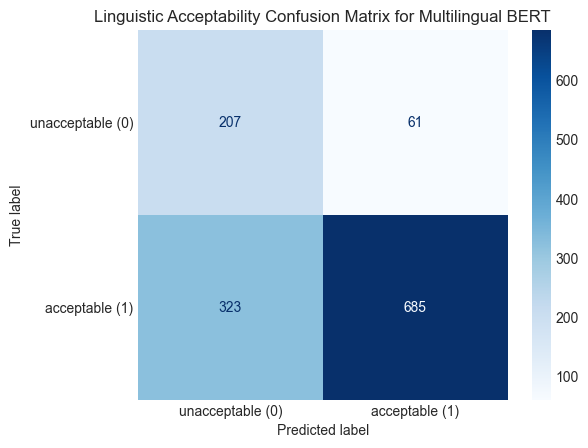

Confusion matrix (rows = true, cols = pred):
 [[ 11 257]
 [ 38 970]]


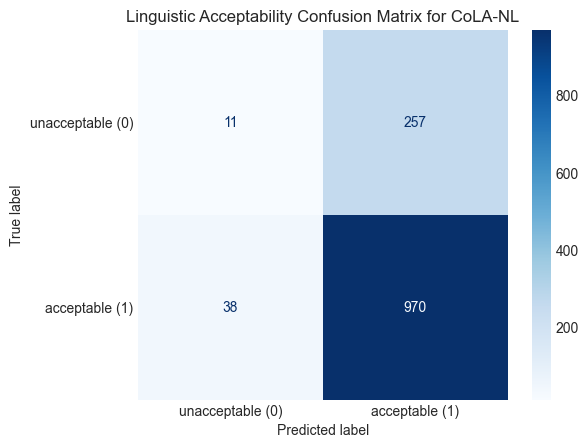

In [ ]:
# Define model names and normal colors
model_files = {
    'google-bert_bert-base-multilingual-cased_predictions.csv': 'Multilingual BERT',
    'GroNLP_bert-base-dutch-cased_predictions.csv': 'BERTje',
    'pdelobelle_robbert-v2-dutch-base_predictions.csv': 'RobBERT',
    'xlm-roberta-base_predictions.csv': 'XLM-RoBERTa',
    'HylkeBr_robbert_dutch-cola_predictions.csv': 'CoLA-NL'
}

# Standard colors
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
model_colors = {model: colors[i] for i, model in enumerate(model_files.values())}

# Calculate metrics for each model
model_metrics = {}
folder_path = Path('model_predictions')

for filename, model_name in model_files.items():
    file_path = folder_path / filename
    
    if file_path.exists():
        df = pd.read_csv(file_path)
        
        # Calculate precision, recall, f1 for each class
        precision, recall, f1, support = precision_recall_fscore_support(
            df['true_label'], df['predicted_label'], average=None
        )
        
        # Get metrics for unacceptable class (label 0)
        unacceptable_precision = precision[0]
        unacceptable_recall = recall[0]
        unacceptable_f1 = f1[0]
        
        # Overall accuracy
        accuracy = accuracy_score(df['true_label'], df['predicted_label'])
        
        model_metrics[model_name] = {
            'unacceptable_precision': unacceptable_precision,
            'unacceptable_recall': unacceptable_recall,
            'unacceptable_f1': unacceptable_f1,
            'accuracy': accuracy
        }
        
        print(f"{model_name}:")
        print(f"  Unacceptable Precision: {unacceptable_precision:.3f}")
        print(f"  Unacceptable Recall: {unacceptable_recall:.3f}")
        print(f"  Unacceptable F1: {unacceptable_f1:.3f}")
        print(f"  Overall Accuracy: {accuracy:.3f}")
        print()


# print confusion matrices for each model
for filename, model_name in model_files.items():
    file_path = folder_path / filename
    
    if file_path.exists():
        df = pd.read_csv(file_path)
        
        # Get true and predicted labels
        y_true = df['true_label']
        y_pred = df['predicted_label']
        
        # Calculate confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        print("Confusion matrix (rows = true, cols = pred):\n", cm)

        # Plot confusion matrix
        disp = ConfusionMatrixDisplay(cm, display_labels=["unacceptable (0)", "acceptable (1)"])
        disp.plot(values_format='d', cmap='Blues')
        plt.title("Linguistic Acceptability Confusion Matrix for " + model_name)
        plt.grid(False)
        plt.show()
